In [1]:
import sys
import os
import importlib
import random
from itertools import combinations

import numpy as np
import scipy
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import prettypyplot as pplt

import mdtraj as md

import ivac
import extq

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [3]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

# Load data

In [4]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load("../../data/raw_feat/cv_dist_spin_anton2.npy"))
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy"))

cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)

traj_inds = util.split_indices(cv_trajs)
print(cv_arr.shape, sb_arr.shape)

(4150115, 2) (4150115, 60)


In [5]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")
sb_models = np.load("../../data/models_centroids_feat2.npy")
sb_ids = [42, 48, 47, 53]

In [6]:
rf161 = list(np.load("../../data/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load("../../data/raw_feat/rf161_anton2.npy"))
rf161_arr = np.concatenate(rf161)
print(rf161_arr.shape)

(4150115, 3)


In [7]:
hb_trajs = list(np.load("../../data/raw_feat/hbonds.npy", allow_pickle=True))
hb_trajs.extend(np.load("../../data/raw_feat/hbonds_anton2.npy", allow_pickle=True))
hb_arr = np.concatenate(hb_trajs)
print(hb_arr.shape)

(4150115, 18)


In [6]:
# load committors
qp_du = np.load("../../data/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[8] # 50 ns
weights = np.load("../../data/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)

# Bin structures by committor

In [7]:
def bin_inds(q, qstep=0.05, low=0, hi=1):
    q_arr = np.concatenate(q)
    nsteps = round((hi - low) / qstep)
    all_inds = []
    steps = np.linspace(low, hi - qstep, nsteps)
    for i, s in enumerate(steps):
        q_inds = ((q_arr >= s) & (q_arr <= s + qstep)).nonzero()[0]
        all_inds.append(q_inds)
    return steps, all_inds

In [8]:
steps, q_inds = bin_inds(qp_du, qstep=0.1, low=0.15, hi=0.85)

In [10]:
X = np.hstack((cv_arr, sb_arr, rf161_arr))

In [16]:
# k = 1 (medoid)
for s, idx in zip(steps, q_inds):
    centroid = np.median(X[idx], axis=0)
    close_id = idx[util.find_closest_points(centroid, X[idx])][0]
    if close_id < 3_000_000:
        ix = util.anton_frame(close_id)
    else:
        ix = ((close_id - 3_000_000) // 10001, (close_id - 3_000_000) % 10001)
    print(ix, np.concatenate(qp_du)[close_id])

0.24351531459113576
(10, 747) None
0.29716208393977683
(7, 2519) None
0.3755145454329931
(126, 172) None
0.4663906064237763
(39, 1680) None
0.6351958636996993
(76, 9243) None
0.706822701865401
(181, 81048) None
0.8130331033273173
(265, 2720) None


In [17]:
# k = 1 (medoid)
for s, idx in zip(steps, q_inds):
    centroid = np.mean(X[idx], axis=0)
    close_id = idx[util.find_closest_points(centroid, X[idx])][0]
    if close_id < 3_000_000:
        ix = util.anton_frame(close_id)
    else:
        ix = ((close_id - 3_000_000) // 10001, (close_id - 3_000_000) % 10001)
    print(ix, np.concatenate(qp_du)[close_id])

(10, 757) 0.22576923511947372
(63, 5764) 0.2881625492810212
(77, 6100) 0.3819554608646824
(292, 2613) 0.49272655494663586
(76, 6764) 0.6099780565282353
(181, 47969) 0.7009625025740219
(135, 1329) 0.8471919207160136


In [12]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

In [16]:
k = 2

clust_objs, centers = [], []
for idx in q_inds:
    km = KMeans(n_clusters=k, )
    km.fit(X[idx])
    cc = km.cluster_centers_
    clust_objs.append(km)
    centers.append(cc)

In [30]:
# find closest structures to each centroid
for s, idx, cc in zip(steps, q_inds, centers):
    print(s)
    for centroid in cc:
        close_id = idx[util.find_closest_points(centroid, X[idx])][0]
        print(close_id, centroid)

0.15
107209 [ -3.61303173 -17.01891603   1.59977678   1.46876876   1.64930683
   2.32079841   2.14306746   1.65081991   0.84247674   1.30202279
   1.55330743   1.66462929   1.64134336   1.16449929   0.96794231
   1.69661508   1.88790509   1.4428612    1.32313966   0.93516526
   1.3681152    2.13581023   2.36113856   1.56619233   1.20470987
   1.00014394   1.75438818   2.48661097   2.80903554   1.93153536
   1.47356467   1.40613638   1.89280076   1.5278009    1.86912138
   2.79894934   2.85640688   2.27121626   0.45501465   0.73067877
   1.08153185   1.63345001   2.15724556   1.54406066   0.54404923
   1.491623     1.63415198   0.96493756   1.40702933   0.82337897
   1.40272696   2.33535867   2.55536776   1.05931073   0.73898517
   0.49485489   2.04909492   2.85163311   3.24657231   1.85994684
   1.25933894   1.25680028   0.96132197   0.47986865   1.1622223 ]
1958304 [ -1.90316152 -41.15028677   1.67144376   1.37533324   1.57097651
   2.47487081   2.40298191   1.90835307   0.92864384   

In [38]:
print(util.anton_frame(1422762))
print((3813770 - 3_000_000) // 10001, (3813770 - 3_000_000) % 10001)

(142, 2762)
81 3689


In [36]:
util.anton_frame(2542790)

(196, 2790)

1. 0.15: both look different (R226 up/down)
1. 0.25: slightly different
1. 0.35: difference mostly in S4 helix
1. 0.45: first centroid seems like noise
1. 0.55: second centroid looks wrong  
1. 0.65: pretty similar
1. 0.75: very different, one centroid is basically up+ state

In [40]:
for s, idx, cc in zip(steps, q_inds, centers):
    print(np.linalg.norm(cc[0] - cc[1]))

24.20849060210739
20.99182666980061
17.193267414788117
21.24718487174193
14.227325864868753
13.700265072645712
45.157088550962584


## Different numbers of clusters

In [13]:
k = 3

clust_objs, centers = [], []
for idx in q_inds:
    km = KMeans(n_clusters=k)
    km.fit(X[idx])
    cc = km.cluster_centers_
    clust_objs.append(km)
    centers.append(cc)

In [14]:
# find closest structures to each centroid
for s, idx, cc in zip(steps, q_inds, centers):
    print(s)
    for centroid in cc:
        close_id = idx[util.find_closest_points(centroid, X[idx])][0]
        if close_id < 3_000_000:
            ix = util.anton_frame(close_id)
        else:
            ix = ((close_id - 3_000_000) // 10001, (close_id - 3_000_000) % 10001)
        print(ix, centroid)

0.15
(71, 6992) [ -3.9240293  -11.30458167   1.58026504   1.5138387    1.63548055
   2.28049442   2.08568089   1.58911955   0.84205032   1.33597931
   1.57557496   1.66075671   1.606623     1.13399179   0.96954637
   1.72176076   1.90671294   1.44328904   1.29790871   0.92617407
   1.37806122   2.1663504    2.37951436   1.56016495   1.17210552
   1.00134952   1.78331057   2.52830113   2.84012579   1.93685116
   1.43554592   1.40778293   1.86658547   1.56148666   1.85741014
   2.75924249   2.79839502   2.21075931   0.44224598   0.74813679
   1.10814283   1.63721817   2.14088253   1.51963075   0.55438809
   1.51773753   1.63856166   0.95513702   1.38796784   0.8011829
   1.41920579   2.37191583   2.56965042   1.04082045   0.70365708
   0.51905979   2.06638786   2.88985757   3.2608848    1.84506334
   1.1941598    1.2526754    0.97002533   0.48479707   1.1653905 ]
(37, 5445) [ -1.84699575 -43.47820814   1.66773256   1.37178419   1.55436856
   2.47885285   2.41642529   1.91995575   0.93558

# smaller steps

In [12]:
steps, q_inds = bin_inds(qp_du, qstep=0.05, low=0.15, hi=0.85)

In [19]:
# k = 1 (medoid)
for s, idx in zip(steps, q_inds):
    centroid = np.mean(X[idx], axis=0)
    close_id = idx[util.find_closest_points(centroid, X[idx])][0]
    if close_id < 3_000_000:
        ix = util.anton_frame(close_id)
    else:
        ix = ((close_id - 3_000_000) // 10001, (close_id - 3_000_000) % 10001)
    print(ix, np.concatenate(qp_du)[close_id])

(111, 2785) 0.15426557260704843
(57, 3817) 0.22176992769688347
(117, 6943) 0.2939757699527264
(126, 1143) 0.32789157581861916
(126, 230) 0.3871137525478827
(77, 1091) 0.4386426738848317
(73, 1494) 0.45538257637681795
(244, 4037) 0.5229845449468782
(76, 9078) 0.5987507613780512
(76, 6949) 0.6433620429529914
(181, 42948) 0.672256829653218
(217, 8597) 0.7460587392676538
(81, 7326) 0.7859503453078944
(184, 45630) 0.8459133279956096


In [15]:
# sample 10 structures from each committor bin
structure_ids = []
for s, idx in zip(steps, q_inds):
    top_ten = np.random.choice(idx, 10, replace=False)
    structure_ids.append(top_ten)

In [16]:
structure_ids

[array([3038793, 2152557, 1161242, 2589632, 3066338,  154603, 3014598,
         191775, 3124531, 3513917]),
 array([3762327, 3076293, 3620264, 3997575, 3405244, 3157632, 3999056,
        2153912, 2511249, 3486118]),
 array([3090606,  192269, 2156760, 2093860, 2746171, 3767534, 3215006,
        2108306,  719972, 3752317]),
 array([  73341, 1056865, 2097357, 2618665,   73135, 1052624, 1994401,
        3254902, 3106387, 2575266]),
 array([1059420, 2137520,   74040,  264336, 1265653,  685630,  105827,
        2653217, 3334350, 3030285]),
 array([3364637, 3095013, 3925823, 3786300, 3249986, 2513954, 2612797,
        3736922, 1255152, 3454074]),
 array([3246012, 3397523, 3421629, 3165998, 3249652, 2625741, 3273032,
        4058839, 3244674, 3466714]),
 array([3758709, 2625609, 4065548, 3776335, 4047376, 3460495,  225057,
        2942663,  262571, 3109288]),
 array([3206259, 3462890, 4110109, 2006537,  769409, 1052905, 2942570,
        4067094, 2981567, 2991662]),
 array([ 706318, 2631229, 26

In [31]:

remove = {1282,
    1283,
    1284,
    1285,
    1286,
    1288,
    1289,
    1290,
    1187,
    1188,
    1189,
    1190,
    1191,
    1197,
    1198,
    1199,
    1203,
    1205,
    1206,
    1207,
    1211,
    1212,
    1213,
    1214,
    1215,
    1225,
    1226,
    1227,
    1228,
    1231,
    1232,
    1233,
    1236,
    1237,
    1238,
    1242,
    1245,
    1246,
    1252,
    1253,
    1260,
    1261,
    1262,
    1263,
    1266,
    1267,
    1268,
    1269,
    1270,
    1271,
    1272,
    1273,
    1274,
    1275,
    1276,
    1277,
    1278,
    1279,
}
# for i in range(295):
#     if (i + 1000) not in remove:
#         files.append(f"/project/dinner/scguo/anton-old/xtc1000ns/civsd-{i}.xtc")
# anton_files = []
# for i in range(3, 82):
#     anton_files.append(f"/project/dinner/scguo/ci-vsd/anton2/prot/civsd.prot.{i}.xtc")
# for i in range(83, 119):
#     anton_files.append(f"/project/dinner/scguo/ci-vsd/anton2/prot/civsd.prot.{i}.xtc")
files = []
for i in range(295):
    if (i + 1000) not in remove:
        files.append(f"/project/dinner/scguo/anton-old/civsd_{i}.dcd")
anton_files = []
for i in range(3, 119):
    if i == 82:
        pass
    anton_files.append(f"/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.{i}.dcd")

In [22]:
with open("structure_ids_q15_85_05.txt", mode="w") as f:
    for top_ten in structure_ids:
        for close_id in top_ten:
            if close_id < 3_000_000:
                ix = util.anton_frame(close_id)
                # print(ix)
                f.write(f"/project/dinner/scguo/anton-old/xtc1000ns/civsd-{ix[0]}.xtc\t{ix[1]}\n")
            else:
                ix = ((close_id - 3_000_000) // 10001, (close_id - 3_000_000) % 10001)
                f.write(f"{anton_files[ix[0]]}\t{ix[1]}\n")

# Sample structures to bin at each committor

In [37]:
for top in np.split(np.random.choice(q_inds[0], 2000, replace=False), 10):
    for close_id in top:
        if close_id < 3_000_000:
            ix = util.anton_frame(close_id)
            print(ix)
        else:
            ix = ((close_id - 3_000_000) // 10001, (close_id - 3_000_000) % 10001)
            print(ix)

(14, 9970)
(182, 48770)
(48, 7430)
(23, 4549)
(20, 7070)
(179, 43645)
(91, 1780)
(219, 8345)
(14, 6047)
(7, 3009)
(204, 4420)
(116, 2232)
(182, 57584)
(179, 74702)
(6, 8948)
(121, 5286)
(63, 2649)
(67, 6213)
(151, 4460)
(181, 8085)
(14, 9652)
(151, 8705)
(7, 9258)
(21, 7382)
(171, 9574)
(7, 4776)
(21, 7770)
(67, 2796)
(121, 4951)
(2, 5776)
(65, 9690)
(10, 1562)
(35, 6115)
(12, 4083)
(23, 7495)
(247, 6510)
(182, 62372)
(89, 6565)
(76, 5286)
(182, 59858)
(48, 8972)
(99, 8502)
(59, 6830)
(179, 46783)
(103, 9755)
(62, 3019)
(63, 2301)
(119, 1061)
(15, 594)
(57, 8460)
(210, 8085)
(121, 8088)
(113, 1126)
(12, 6498)
(49, 5032)
(76, 3632)
(12, 5795)
(114, 1796)
(63, 9627)
(114, 8289)
(99, 7004)
(249, 1350)
(38, 9526)
(108, 5115)
(92, 7878)
(48, 6266)
(6, 3215)
(121, 9127)
(111, 400)
(4, 9270)
(69, 4840)
(69, 3475)
(106, 97)
(105, 3461)
(110, 8430)
(15, 8785)
(25, 5526)
(101, 4009)
(15, 5312)
(10, 3249)
(101, 7947)
(182, 3942)
(91, 8392)
(116, 4632)
(19, 2048)
(38, 7962)
(119, 9085)
(182, 45643

In [38]:
# sample 10 structures from each committor bin
steps, q_inds = bin_inds(qp_du, qstep=0.1, low=0.15, hi=0.85)
n = 200
for s, idx in zip(steps, q_inds):
    all_top = np.random.choice(idx, n * 10, replace=False)
    for i, top in enumerate(np.split(all_top, 10)):
        with open(f"../../data/q_bin/q_{(s + 0.05) * 10:.0f}_{i}.txt", mode="w") as f:
            for close_id in top:
                if close_id < 3_000_000:
                    ix = util.anton_frame(close_id)
                    print(ix)
                    f.write(f"/project/dinner/scguo/anton-old/civsd_{ix[0]}.dcd\t{ix[1]}\n")
                else:
                    ix = ((close_id - 3_000_000) // 10001, (close_id - 3_000_000) % 10001)
                    f.write(f"{anton_files[ix[0]]}\t{ix[1]}\n")

(182, 98521)
(62, 5130)
(15, 8309)
(71, 6644)
(120, 5092)
(55, 7178)
(69, 6980)
(182, 33929)
(126, 4942)
(280, 8623)
(182, 96494)
(179, 46740)
(119, 8959)
(119, 8430)
(182, 97598)
(64, 2557)
(249, 5082)
(19, 3791)
(21, 278)
(64, 6218)
(106, 1044)
(182, 21547)
(182, 59414)
(249, 7356)
(193, 7950)
(249, 5108)
(21, 954)
(182, 99074)
(117, 2311)
(105, 3570)
(61, 5090)
(15, 6391)
(151, 7828)
(182, 53913)
(26, 6066)
(12, 1492)
(181, 2254)
(182, 33802)
(151, 6210)
(249, 1889)
(15, 4640)
(10, 1744)
(151, 4443)
(63, 2606)
(119, 7723)
(121, 7254)
(21, 6128)
(219, 8386)
(12, 7269)
(62, 4942)
(180, 80031)
(65, 1817)
(180, 83006)
(102, 9398)
(151, 9018)
(182, 85171)
(235, 6536)
(6, 4605)
(63, 1715)
(182, 96664)
(235, 6437)
(119, 9007)
(15, 9654)
(202, 8344)
(220, 9007)
(235, 4438)
(181, 787)
(55, 7233)
(114, 8621)
(182, 74633)
(2, 6927)
(121, 8487)
(22, 1056)
(19, 2263)
(118, 190)
(178, 6927)
(182, 58796)
(208, 2538)
(182, 49253)
(182, 33654)
(71, 4808)
(179, 34985)
(64, 6169)
(19, 3047)
(21, 3069)

# Cluster transition state points RMSD

In [9]:
import glob

In [10]:
# load points (2000) at q_+ 0.5
topfile = "/project/dinner/scguo/ci-vsd/models/MD-clustering-center/civsd.psf"
tstate = md.load(glob.glob("../../data/q_bin/q5*.xtc"), top=topfile)

In [28]:
distances = np.empty((tstate.n_frames, tstate.n_frames))
prot_ids = tstate.top.select("protein")
for i in range(tstate.n_frames):
    distances[i] = md.rmsd(tstate, tstate, i, atom_indices=prot_ids)
print('Max pairwise rmsd: %f nm' % np.max(distances))

Max pairwise rmsd: 0.789938 nm


In [39]:
# np.save("../../data/q_bin/q5_rmsd_square.npy", distances)


In [11]:
import kmedoids

In [30]:
assert np.all(distances - distances.T) < 1e-6

In [31]:
c = kmedoids.fasterpam(distances, 5)

In [36]:
print(c.labels)

[3 3 2 ... 0 2 2]


In [37]:
print(c.medoids)

[  65   83 1257   28  979]


In [38]:
print(c.loss)

633.6469441056252


In [40]:
all_c = []
for i in range(1, 9):
    c = kmedoids.fasterpam(distances, i)
    print(c)
    all_c.append(c)

KMedoidsResult(loss=741.219775930047, labels=[0 0 0 ... 0 0 0], medoids=[915], n_iter=1, n_swaps=1)
KMedoidsResult(loss=675.3795684427023, labels=[1 1 0 ... 1 0 0], medoids=[531 141], n_iter=2, n_swaps=14)
KMedoidsResult(loss=660.2649123072624, labels=[0 0 1 ... 0 1 1], medoids=[  28  531 1964], n_iter=2, n_swaps=20)
KMedoidsResult(loss=645.1185073703527, labels=[2 2 3 ... 2 3 3], medoids=[ 83 979 141 353], n_iter=2, n_swaps=28)
KMedoidsResult(loss=632.7390917390585, labels=[3 3 2 ... 0 2 2], medoids=[352  83 531  28 979], n_iter=3, n_swaps=26)
KMedoidsResult(loss=625.1127367168665, labels=[3 3 2 ... 1 2 2], medoids=[  83   65 1881   28  979 1576], n_iter=3, n_swaps=47)
KMedoidsResult(loss=618.2144456803799, labels=[0 0 4 ... 0 4 4], medoids=[  28 1726   83  979 1257 1964  716], n_iter=3, n_swaps=43)
KMedoidsResult(loss=610.8584765344858, labels=[0 0 3 ... 0 7 7], medoids=[  28  716 1726 1388   83 1964  979  531], n_iter=3, n_swaps=40)


In [54]:
np.count_nonzero(all_c[4].labels == 4)

137

In [45]:
for c in all_c:
    print("Result:")
    for m in c.medoids:
        i = m // 200
        j = m % 200
        with open(f"../../data/q_bin/q_5_{int(i)}.txt", mode='r') as f:
            lines = f.readlines()
            print(lines[int(j)].strip("\n"))

Result:
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.30.dcd	2465
Result:
/project/dinner/scguo/anton-old/civsd_2.dcd	981
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.51.dcd	1048
Result:
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.25.dcd	1226
/project/dinner/scguo/anton-old/civsd_2.dcd	981
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.63.dcd	4857
Result:
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.105.dcd	7464
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.17.dcd	364
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.51.dcd	1048
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.20.dcd	620
Result:
/project/dinner/scguo/anton-old/civsd_1.dcd	2647
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.105.dcd	7464
/project/dinner/scguo/anton-old/civsd_2.dcd	981
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.25.dcd	1226
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.17.dcd	364
Result:
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.105.dcd	7464
/pr

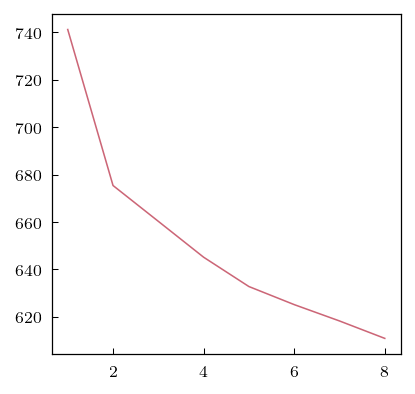

In [41]:
plt.plot(range(1, 9), [c.loss for c in all_c])

## compute RMSD for non-hydrogen atoms

In [57]:
prot_noh_ids = tstate.top.select("protein and not element H")

In [60]:
distances_noh = np.empty((tstate.n_frames, tstate.n_frames))
for i in range(tstate.n_frames):
    distances_noh[i] = md.rmsd(tstate, tstate, i, atom_indices=prot_noh_ids)
print('Max pairwise rmsd: %f nm' % np.max(distances_noh))

Max pairwise rmsd: 0.779073 nm


In [61]:
all_c = []
for i in range(1, 9):
    c = kmedoids.fasterpam(distances_noh, i)
    print(c)
    all_c.append(c)

KMedoidsResult(loss=691.3234915584326, labels=[0 0 0 ... 0 0 0], medoids=[1964], n_iter=1, n_swaps=1)
KMedoidsResult(loss=627.9184813201427, labels=[0 0 1 ... 0 1 1], medoids=[ 28 353], n_iter=2, n_swaps=12)
KMedoidsResult(loss=610.194228976965, labels=[0 0 1 ... 0 1 1], medoids=[141 353 979], n_iter=3, n_swaps=14)
KMedoidsResult(loss=595.093195348978, labels=[1 1 0 ... 1 0 0], medoids=[1257   28  979 1075], n_iter=3, n_swaps=23)
KMedoidsResult(loss=582.8280957192183, labels=[3 3 0 ... 3 0 0], medoids=[1257 1459  979   28 1075], n_iter=2, n_swaps=34)
KMedoidsResult(loss=573.5623411387205, labels=[1 1 0 ... 3 0 0], medoids=[1257   28   55   65   83  979], n_iter=3, n_swaps=42)
KMedoidsResult(loss=569.0345738083124, labels=[1 1 6 ... 1 6 6], medoids=[1576   23  687  716 1196  979 1881], n_iter=3, n_swaps=34)
KMedoidsResult(loss=560.8772230893373, labels=[7 7 0 ... 6 0 0], medoids=[1257 1726  716 1196   83  979 1964   23], n_iter=5, n_swaps=50)


In [62]:
for c in all_c:
    print("Result:")
    for m in c.medoids:
        i = m // 200
        j = m % 200
        with open(f"../../data/q_bin/q_5_{int(i)}.txt", mode='r') as f:
            lines = f.readlines()
            print(lines[int(j)].strip("\n"))

Result:
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.63.dcd	4857
Result:
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.25.dcd	1226
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.20.dcd	620
Result:
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.51.dcd	1048
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.20.dcd	620
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.17.dcd	364
Result:
/project/dinner/scguo/anton-old/civsd_6.dcd	3991
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.25.dcd	1226
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.17.dcd	364
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.19.dcd	3881
Result:
/project/dinner/scguo/anton-old/civsd_6.dcd	3991
/project/dinner/scguo/anton-old/civsd_7.dcd	2490
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.17.dcd	364
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.25.dcd	1226
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.19.dcd	3881
Result:
/project/dinner/scguo/anton-old/civsd_6.dcd	3991
/beag

In [12]:
# np.save("../../data/q_bin/q5_rmsd_noh_square.npy", )
distances = np.load("../../data/q_bin/q5_rmsd_noh_square.npy")

In [13]:
c = kmedoids.fasterpam(distances, 2)

In [15]:
c.medoids

array([353,  28], dtype=uint64)

In [16]:
print(np.count_nonzero(c.labels == 0), np.count_nonzero(c.labels == 1))

1029 939


## Hierarchical clustering

In [17]:
prot_noh_ids = tstate.top.select("protein and not element H")

In [18]:
distances_noh = np.load("../../data/q_bin/q5_rmsd_noh_square.npy")

In [19]:
from sklearn.cluster import AgglomerativeClustering

In [22]:
ac = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='single', distance_threshold=0.35)
labels = ac.fit_predict(distances_noh)
print(ac.n_clusters_)
print(labels)

1
[0 0 0 ... 0 0 0]


In [13]:
def compute_inter_rmsd(tstate):
    # tstate: md.Trajectory
    prot_noh_ids = tstate.top.select("protein and not element H")
    distances_noh = np.empty((tstate.n_frames, tstate.n_frames))
    for i in range(tstate.n_frames):
        distances_noh[i] = md.rmsd(tstate, tstate, i, atom_indices=prot_noh_ids)
    return distances_noh

In [15]:
import glob

In [39]:
# do for each committor bin:
cluster_objs = []
distances = []
for i in range(2, 9):
    if i == 5:
        continue
    topfile = "/project/dinner/scguo/ci-vsd/models/MD-clustering-center/civsd.psf"
    tstate = md.load(glob.glob(f"../../data/q_bin/q{i}*.xtc"), top=topfile)
    distances_noh = compute_inter_rmsd(tstate)
    print(f'Max pairwise rmsd: {np.max(distances_noh) * 10} Å')
    distances.append(distances_noh)
    
    ac = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='single', distance_threshold=0.35)
    labels = ac.fit_predict(distances_noh)
    cluster_objs.append(ac)

Max pairwise rmsd: 8.725069761276245 Å
Max pairwise rmsd: 9.103167057037354 Å
Max pairwise rmsd: 8.33199143409729 Å
Max pairwise rmsd: 8.370215892791748 Å
Max pairwise rmsd: 7.968016862869263 Å
Max pairwise rmsd: 7.772918343544006 Å


In [40]:
for c in cluster_objs:
    print(c.n_clusters_, c.labels_)

3 [0 0 0 ... 0 0 0]
2 [0 0 0 ... 0 0 0]
1 [0 0 0 ... 0 0 0]
3 [0 0 0 ... 0 0 0]
3 [0 0 0 ... 0 0 0]
1 [0 0 0 ... 0 0 0]


In [41]:
import kmedoids

In [42]:
# find medoid of each slice
km_objs = []
for d, clust in zip(distances, cluster_objs):
    k = clust.n_clusters_
    c = kmedoids.fasterpam(d, k)
    km_objs.append(c)

In [43]:
for q, km in zip((2, 3, 4, 6, 7, 8), km_objs):
    print(km.medoids)
    for m in km.medoids:
        i = m // 200
        j = m % 200
        with open(f"../../data/q_bin/q_{q}_{int(i)}.txt", mode='r') as f:
            lines = f.readlines()
            print(lines[int(j)].strip("\n"))

[1952 1537 1687]
/project/dinner/scguo/anton-old/civsd_67.dcd	1079
/project/dinner/scguo/anton-old/civsd_249.dcd	357
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.21.dcd	9301
[ 411 1103]
/project/dinner/scguo/anton-old/civsd_208.dcd	1526
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.18.dcd	4352
[1338]
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.24.dcd	7061
[ 352 1135 1637]
/project/dinner/scguo/anton-old/civsd_292.dcd	8709
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.32.dcd	4211
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.85.dcd	6102
[1963  951  862]
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.91.dcd	5962
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.64.dcd	3053
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.23.dcd	1574
[1080]
/project/dinner/scguo/anton-old/civsd_39.dcd	2179
